# Rocket Dynamics

We are interested in modelling the dynamics of a water rocket travelling horizontally along a track.

This notebook is available at https://github.com/jameskermode/rocket


In [ ]:
using PyPlot
rc("lines", linewidth=2)
rc("font", size=14)

## Numerical Simulation

We discretize time in small steps $\Delta t$ and compute: 

- pressure in the tank $P_t$, falling from launch pressure $P_l$ following adiabatic gas expansion law 
  
\begin{equation*}
pV^\gamma = \mathrm{constant}
\end{equation*}
  
- exhaust velocity $v_e$, from Bernoulli's equation and conservation of the volume rate of flow 
  
\begin{equation*}
A_b v_b = A_n v_e
\end{equation*}
 
- volume flow rate from nozzle area $A_n$ 
  
\begin{equation*}  
\frac{dV}{dt} = v_e A_n
\end{equation*}
  
- mass flow rate, where $\rho_w$ is the density of water
  
\begin{equation*}  
\frac{dm}{dt} = \rho_w \frac{dV}{dt}
\end{equation*}
  
- remaining total mass, and volumes of water and air
- forward thrust force due to ejection of fuel 
  
\begin{equation*}  
  F_t = v_e \frac{dm}{dt}
\end{equation*}
  
- drag force 

\begin{equation*}
  F_d = \frac{1}{2}C_d\rho_a v^2
\end{equation*}
  
- forces opposing motion: either frictional rolling resistance $F_r = - \mu mg$ or gravity $F_g = - mg$, depending on orientation of rocket

- finally, we update the acceleration, velocity and position using the total force 

\begin{eqnarray*}
    F(t) & = & F_t + F_d + F_r \\
    a(t) & = & \frac{F(t)}{m(t)} \\
    v(t) & = & \int a(t)\; dt \\
    x(t) & = & \int v(t)\; dt    
\end{eqnarray*}

## Parameters

In [11]:
dt = 0.001 # timestep, s
N = 5000 #  number of steps 
m0 = 0.500 # empty mass, kg
A = 7.0e-3 # silhouette area, m^2
Cd = .7 # drag coefficient
rho_a = 1.2 # air density kg/m^3
P_a = 1e5 # air pressure, N/m^2
rho_w = 1000.0 # water density, kg/m^3
V_t = 6.0e-4 # tank volume, m^3
f = 0.3 # fill fraction
D_n = 6e-3 # nozzle diameter, m
P_l = 3e5 # launch pressure, N/m^2
D_t = 6.7e-2 # tank diameter, m
mu = 5e-2 # rolling friction
g = 9.81 # acceleration due to gravity, m/s^2
gamma = 1.4 # ratio of heat capacities Cp/Cv
vertical = true # if true, rocket travels vertically against gravity

a_threshold = 0.1 # threshold acceleration for detecting launch, m/s^2
nothing

In [12]:
function run_model()    
    t = collect(0:dt:N*dt)
    x = zeros(N+1)
    v = zeros(N+1)
    a = zeros(N+1)

    P_t = zeros(N+1)
    P_t[1] = P_l
    v_e = zeros(N+1)

    A_n = pi*(D_n/2)^2 # nozzle area, m^2
    A_t = pi*(D_t/2)^2 # tank area, m^2
    area_ratio = A_n/A_t
    V_w = f*V_t
    V_a = (1-f)*V_t

    for n = 1:N
        # Verlet integration of the positions
        x[n+1] = x[n] + v[n]*dt + 0.5*a[n]*dt^2

        # pressure in the tank, from adiabatic gas expansion
        if V_w <= 0.0
            P_t[n+1] = P_a
        else
            P_t[n+1] = P_l*(V_t*(1-f)/V_a^gamma)
        end

        # exhaust velocity, from Bernoulli
        v_e[n+1] = sqrt((P_t[n+1] - P_a)/(rho_w*(1 - area_ratio^2)))
        dV_dt = v_e[n+1]*A_n
        dm_dt = dV_dt*rho_w

        # update volumes of water and air in tank
        V_w = V_w - dV_dt*dt
        V_a = V_t - V_w

        m = m0 + V_w*rho_w # remaining total mass

        F_thrust = v_e[n+1]*dm_dt
        F_drag = - 0.5*A*Cd*rho_a*v[n]^2*sign(v[n]) # drag opposes motion
        if (vertical)
            F_ext = - m*g # gravity opposes motion
        else
            F_ext = - mu*m*g # friction opposes motion
        end
        F_total = F_thrust + F_drag + F_ext

        # acceleration = force/massa
        a[n+1] = F_total/m

        # update velocities with Verlet algorithm
        v[n+1] = v[n] + (a[n+1] + a[n])/2*dt
    end

    subplot(313)
    plot(t,x)
    xlim(0,N*dt)
    xlabel("Time / s")
    ylabel("Position / m")
    axhline(0; color="k", linestyle="dashed", label="_nolegend_")
    ylim(0, 60)    

    subplot(312)
    plot(t,v)
    ylabel("Velocity / m/s")
    xlim(0,N*dt)
    axhline(0; color="k", linestyle="dashed", label="_nolegend_")

    subplot(311)
    plot(t,a)
    ylabel("Accel / m/s^2")
    xlim(0,N*dt)
    axhline(0; color="k", linestyle="dashed", label="_nolegend_")

    (x, v, a)
end

run_model (generic function with 1 method)

## Varying water filling

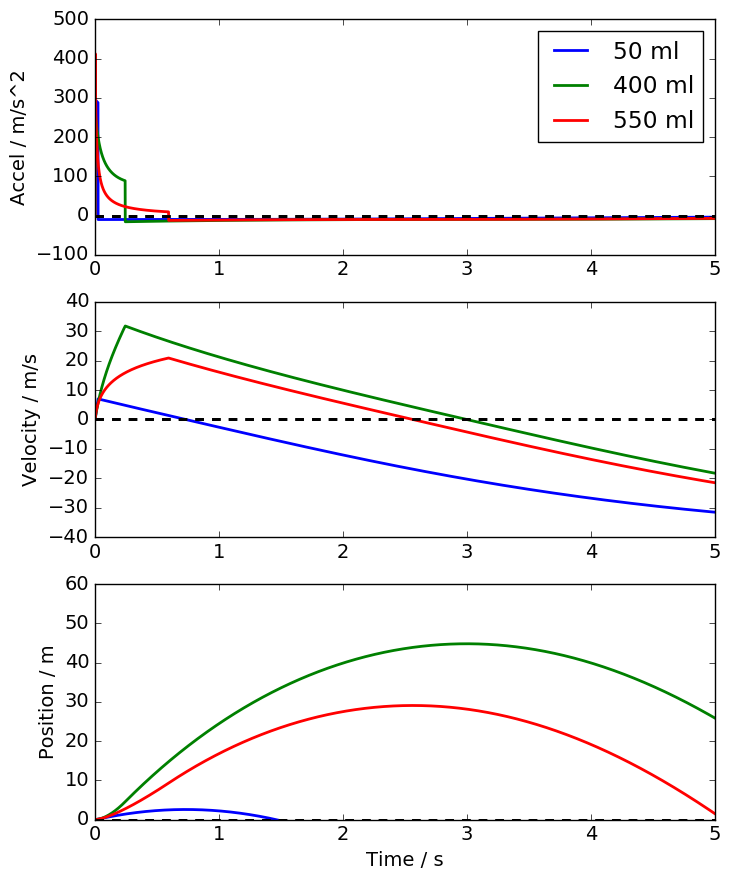

PyObject <matplotlib.legend.Legend object at 0x323aedc50>

In [13]:
figure(figsize=(8,10))

f = 50/600
run_model()

f = 400/600
run_model()

f = 550/600
run_model()

legend(["50 ml", "400 ml", "550 ml"])

## Varying nozzle diameter

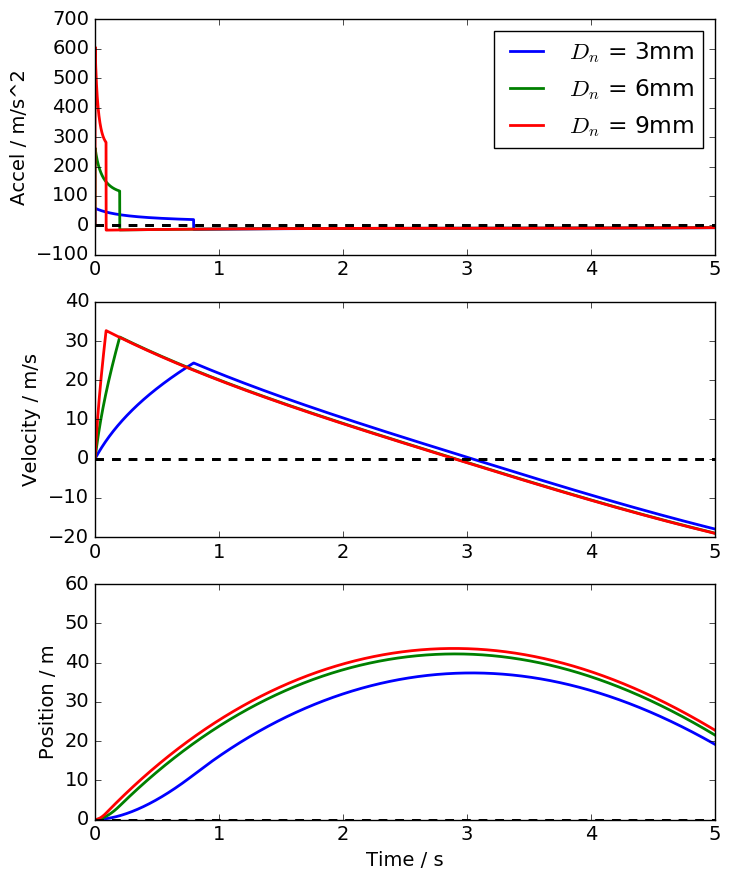

PyObject <matplotlib.legend.Legend object at 0x32423dc90>

In [14]:
figure(figsize=(8,10))

f = 350/600

D_n = 3e-3
run_model()

D_n = 6e-3
run_model()

D_n = 9e-3
run_model()

legend([L"$D_n$ = 3mm"; L"$D_n$ = 6mm"; L"$D_n$ = 9mm"])

---

## Data Analysis - calibration of accelerometer

In [ ]:
using DataFrames
caldata = readtable("CALIBRATION.CSV")
plot(caldata[:X_mm_s_2_])
plot(caldata[:Y_mm_s_2_])
plot(caldata[:Z_mm_s_2_])
legend(["acc_x", "acc_y", "acc_z"])

In [ ]:
g1 = mean(abs(caldata[:Y_mm_s_2_][1:200]))
g2 = mean(abs(caldata[:Z_mm_s_2_][250:500]))
g3 = mean(abs(caldata[:X_mm_s_2_][700:1110]))

acc_conv = g/mean([g1, g2, g3])
t_conv = 1e-3

## Rocket accelerometer data

In [ ]:
fns = filter(r"DAT_.*\.CSV", readdir())
for (i, fn) in enumerate(fns)
    println(fn)    
    data = readtable(fn)
    subplot(length(fns),1,i)
    plot(data[:Time_ms_]*t_conv, data[:X_mm_s_2_]*acc_conv)
end

## Smoothing the data with a Kalman filter

In [ ]:
include("kalman.jl")

peak_a = Dict()
peak_v = Dict()

figure(figsize=(8,10))
for fn in [fns[3:5]]
    # fn = fns[2]
    println(fn)

    # extract t and accel data and convert to SI units
    data = readtable(fn)
    t = data[:Time_ms_] * t_conv
    a = data[:X_mm_s_2_] * acc_conv
    
    # use Kalman filter to smooth acceleration data
    A, G, Q, R = 1.0, 1.0, 0.0, 1.0
    x_hat_0, Sigma_0 = 0.0, 1.0
    kalman = Kalman(A, G, Q, R)
    set_state!(kalman, x_hat_0, Sigma_0)
    ahat = zeros(length(a))
    sigma = zeros(length(a))
    for i=1:length(t)
        update!(kalman, a[i])
        ahat[i] = kalman.cur_x_hat
        sigma[i] = kalman.cur_sigma
    end
    
    # look for rising edge in acceleration, and shift to t=0
    # truncate after a few seconds, before errors get too big
#     start = find(ahat .> a_threshold)[1]
#     println("start=$start")
#     if (start > 30) start -= 30

    start = 200
    t = t[start:end]
    t -= t[1]
    ahat = ahat[start:end]
        
    # integrate acceleration wrt time to get velocity and position
    vhat = cumtrapz(t, ahat)
    rhat = cumtrapz(t, vhat)  

    subplot(311)
    plot(t, ahat, label=fn)
    ylabel("Accel / m/s^2")
#     xlim(0, t_max)

    subplot(312)
    plot(t, vhat)
    ylabel("Ve locity / m/s")
#     xlim(0, t_max)    

    subplot(313)
    plot(t, rhat)
    ylabel("Position / m")
#     xlim(0, t_max)    
    
    peak_a[fn] = maximum(ahat)
    peak_v[fn] = maximum(vhat)
end

subplot(311)
legend()

In [ ]:
maximum(ahat)

## Print summary statistics

In [ ]:
for fn in fns
    @printf("%s: peak accel %.2f m/s^2, peak velocity %.2f m/s\n", fn, peak_a[fn], peak_v[fn])
end

# Vertical launch experimental data

In [72]:
using DataFrames
expt = readtable("expt.csv")

,Nozzle,Volume,Attempt_1,Attempt_2,Attempt_3,Height,Error
1,7.0,200,17.86,NA,11.99,14.925,2.94
2,7.0,300,15.09,10.57,NA,12.83,2.26
3,7.0,400,3.86,5.65,3.86,4.456666667,0.84
4,8.0,200,18.01,16.0,12.4,15.47,2.32
5,8.0,300,20.56,13.7,12.29,15.51666667,3.61
6,8.0,400,7.94,8.07,4.96,6.99,1.44
7,9.0,200,10.39,12.7,10.91,11.33333333,0.99
8,9.0,300,8.49,8.22,4.91,7.206666667,1.63
9,9.0,400,2.73,3.5,2.04,2.756666667,0.6
10,7.5,200,15.07,10.4,12.74,12.73666667,1.91


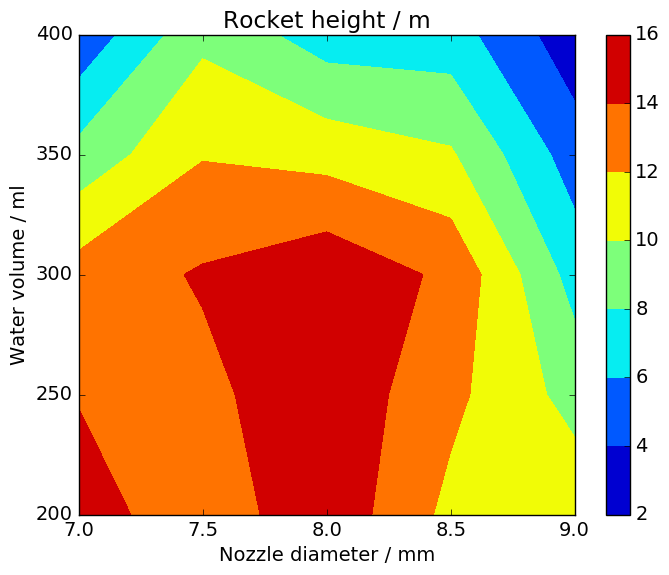

PyObject <matplotlib.text.Text object at 0x328929850>

In [73]:
using PyCall
@pyimport matplotlib.mlab as mlab

N = collect(7:.5:9)
V = collect(200:50:400)
H = mlab.griddata(expt[:Nozzle], expt[:Volume], expt[:Height], N, V; interp="linear")
contourf(N, V, H)
xlabel("Nozzle diameter / mm")
ylabel("Water volume / ml")
colorbar()
title("Rocket height / m")